In [ ]:
import pandas as pd
import datetime
import pytz

import kagglehub

import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_chosenClassOriginal = pd.read_csv('[LOCAL ONDE ARQUIVO FOI SALVO]/df_uniqueall-paraphrase-multilingual.csv', sep=';', encoding='utf-8') #classe 9 (acervo geral) com 6 clusters

df_chosenClass = df_chosenClassOriginal[['author', 'title', 'publish', 'CDU', 'cluster']].copy()

df_chosenClass.cluster.value_counts()

,count
cluster,
0,4124
1,3694
5,1145
2,1078
4,984
3,834


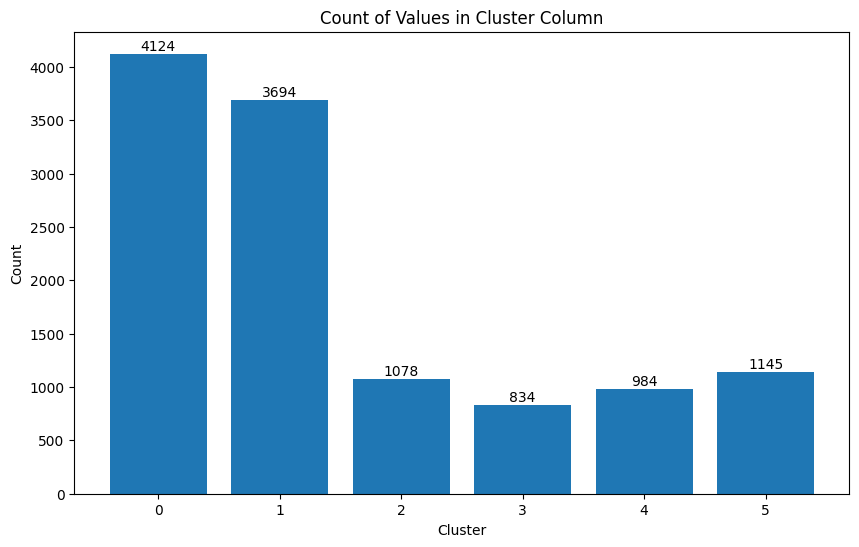

In [ ]:
#@title contagem de valores na coluna df_chosenClass.cluster e inserir rótulo das contagens no gráfico

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_chosenClass is already defined as in your previous code

# Count the values in the 'cluster' column
cluster_counts = df_chosenClass.cluster.value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
bars = plt.bar(cluster_counts.index, cluster_counts.values)

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')


plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Count of Values in Cluster Column')
plt.show()


In [ ]:
df_chosenClass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11859 entries, 0 to 11858
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   10222 non-null  object
 1   title    11859 non-null  object
 2   publish  11858 non-null  object
 3   CDU      11859 non-null  object
 4   cluster  11859 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 463.4+ KB


In [ ]:
#@title Definir parâmetros...
num_clusters = 6 #@param
loop_number = "01" #@param
class_folder = "df_slice_9" #@param
chosen_model = "gemini-2.0-flash" #@param

# Analisando as linhas em cada Cluster

In [ ]:
#@title Objetos df_cluster_X para cada um dos clusters

for i in range(num_clusters):
  globals()[f'df_chosenClass_cluster_{i}'] = df_chosenClass[df_chosenClass['cluster'] == i]


In [ ]:
!pip install -q -U google-generativeai

In [ ]:
from google.colab import userdata
import os
import google.generativeai as genai

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

# EXECUÇÃO PROMPT (final)

In [ ]:
#@title Execução do prompt para análise
""" Você é um especialista em Classificação Decimal Universal (CDU).
Analise a tabela abaixo que é um dos clusters obtidos com o algoritmo K-Means++ (a partir do embedding das colunas .CDU e .title),
o cluster contém informações sobre livros e seus respectivos códigos CDU.
A tabela possui as seguintes colunas: 'title', 'author', 'publish' e 'CDU', ignore a coluna 'cluster'.
Os códigos CDU estão no formato numérico, seguindo a estrutura padrão da CDU.
Identifique e analise os seguintes tipos de relações no cluster (tabela):
Relações hierárquicas (códigos mais específicos dentro de códigos mais gerais).
Associações entre assuntos (códigos que se complementam ou se relacionam).
Se não houver relação entre os códigos, explicitar também essa informação.
Forneça os resultados em formato de lista, indicando:
Os códigos CDU analisados.
As relações encontradas entre os códigos.
Os quantitativos de códigos analisados.
A análise tem como objetivo entender relações ocultas entre os livros na tabela e será utilizada por bibliotecários
e pesquisadores para melhorar a organização e recuperação de informações."""

promptAtual = """ Você é um especialista em Classificação Decimal Universal (CDU).
Analise a tabela abaixo que é um dos clusters obtidos com o algoritmo K-Means++ (a partir do embedding das colunas .CDU e .title),
o cluster contém informações sobre livros e seus respectivos códigos CDU.
A tabela possui as seguintes colunas: 'title', 'author', 'publish' e 'CDU', ignore a coluna 'cluster'.
Os códigos CDU estão no formato numérico, seguindo a estrutura padrão da CDU.
Identifique e analise os seguintes tipos de relações no cluster (tabela):
Relações hierárquicas (códigos mais específicos dentro de códigos mais gerais).
Associações entre assuntos (códigos que se complementam ou se relacionam).
Se não houver relação entre os códigos, explicitar também essa informação.
Forneça os resultados no formato de um texto, indicando as conclusões encontradas sobre:
(1) Os códigos CDU analisados e (2) As relações encontradas entre os códigos.

A análise tem como objetivo entender relações ocultas entre os livros na tabela e será utilizada por bibliotecários
e pesquisadores para melhorar a organização e recuperação de informações.
"""

def get_current_datetime_gmt_minus_3():
  """Gets the current datetime for the GMT-3 timezone."""
  timezone = pytz.timezone('America/Sao_Paulo')
  form_dtime = datetime.datetime.now(timezone).strftime("%d_%m_%Y")
  return form_dtime

form_dtime = get_current_datetime_gmt_minus_3() #< registro na pasta de rede

for k in range(num_clusters):
    # Use get() to avoid KeyError if the DataFrame doesn't exist
    df_cluster = globals().get(f'df_chosenClass_cluster_{k}')

    # 0 definindo o tamanho da amostra do dataframe: fracAmostra
    # Check if the DataFrame exists and is not empty (commons cluster may be empty)
    if df_cluster is not None and not df_cluster.empty:
        cluster_counts = len(df_cluster)
        fracAmostra = float(1.0)
        #if cluster_counts >= 50 and cluster_counts <= 100:
            #fracAmostra = float(0.7)
        #elif cluster_counts >= 100:
            #fracAmostra = float(0.5)
        #elif cluster_counts < 50:
            #fracAmostra = float(0.8)

    folderFrac = str(fracAmostra).replace('.', '') #<< nome da pasta para esta amostra

    # 1 criando uma amostra do dataframe em função de limites no modelo usado
    dataframe = globals()[f'df_chosenClass_cluster_{k}'].sample(frac=fracAmostra).to_string()

    # 2 analisando o dataframe (sua amostra)
    def analyze_code(dataframe, model_name):
      model = genai.GenerativeModel(model_name)
      response = model.generate_content(f'{promptAtual}:\n\n{dataframe}',
      generation_config=genai.types.GenerationConfig(
        # parâmetros
        candidate_count=1,
        #stop_sequences=["x"],
        #max_output_tokens=1024,
        max_output_tokens=3072,
        temperature=0.7,),
      )
      return response.text


    model_folder = "".join(c for c in chosen_model if c.isalnum())

    analysis_result = analyze_code(dataframe, chosen_model) # <<<< Modelo escolhido

    # 3 criando o diretório para exportação (se ainda não existir)

    output_dir = os.path.dirname(f"/content/drive/MyDrive/CodeInTCC/analises/{form_dtime}/{loop_number}/{model_folder}/{class_folder}/{num_clusters}/{folderFrac}/")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 4 exportando a análise para arquivo texto
    fileToSave = f"cluster_{k}.txt"
    try:
        with open(os.path.join(output_dir, fileToSave), "w", encoding="utf-8") as f:
            f.write(analysis_result)
        print(f"Análise do cluster {k} exportada para arquivo texto.")
    except Exception as e:
        print(f"Um erro ocorreu no processo de exportação do cluster {k}: {e}")

    # 5 exportando o cluster em formato .txt
    current_cluster = globals()[f'df_chosenClass_cluster_{k}']
    output_dir = f"/content/drive/MyDrive/CodeInTCC/analises/{form_dtime}/{loop_number}/{model_folder}/{class_folder}/{num_clusters}/clustersEmCSV/"
    os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist
    csv_filename = os.path.join(output_dir, f"cluster_{k}.csv")
    try:
        current_cluster.to_csv(csv_filename, sep=";", encoding="utf-8", index=False)
        print(f"Cluster {k} exportado para {csv_filename}")
    except Exception as e:
        print(f"Erro ao exportar o cluster {k}: {e}")

print("-------------FIM---------------------------")
print(f"---------{num_clusters}-- exportados .txt-- ")


Análise do cluster 0 exportada para arquivo texto.
Cluster 0 exportado para /content/drive/MyDrive/CodeInTCC/analises/01_04_2025/01/gemini20flash/df_slice_9/6/clustersEmCSV/cluster_0.csv
Análise do cluster 1 exportada para arquivo texto.
Cluster 1 exportado para /content/drive/MyDrive/CodeInTCC/analises/01_04_2025/01/gemini20flash/df_slice_9/6/clustersEmCSV/cluster_1.csv
Análise do cluster 2 exportada para arquivo texto.
Cluster 2 exportado para /content/drive/MyDrive/CodeInTCC/analises/01_04_2025/01/gemini20flash/df_slice_9/6/clustersEmCSV/cluster_2.csv
Análise do cluster 3 exportada para arquivo texto.
Cluster 3 exportado para /content/drive/MyDrive/CodeInTCC/analises/01_04_2025/01/gemini20flash/df_slice_9/6/clustersEmCSV/cluster_3.csv
Análise do cluster 4 exportada para arquivo texto.
Cluster 4 exportado para /content/drive/MyDrive/CodeInTCC/analises/01_04_2025/01/gemini20flash/df_slice_9/6/clustersEmCSV/cluster_4.csv
Análise do cluster 5 exportada para arquivo texto.
Cluster 5 expo